# Initial setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict, Counter

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence, pack_padded_sequence

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import seaborn as sns
import tqdm as tqdm
import warnings
import string
import re

warnings.filterwarnings('ignore')
np.random.seed(42)
torch.manual_seed(42)

print("PyTorch version: ", torch.__version__)
print("CUDA available: ", torch.cuda.is_available())

PyTorch version:  2.6.0+cu124
CUDA available:  True


# Basic RNN

In [39]:
class SimpleRNN:
  """
  Basic RNN (Elman) Network:
  "The hidden layer from the previous time step
    provides a form of memory, or context, that encodes earlier processing"

  - g is activation function (typically tanh or ReLU)
  - f is output function (often softmax for classification)
  - U: hidden-to-hidden weights (recurrent connections)
  - W: input-to-hidden weights
  - V: hidden-to-output weights


  h_t = tanh(W_h @ h_{t-1}   +  x_t + b_h )
  y_t = W_t @ h_t   +   b_y
  """

  def __init__(self, input_size, hidden_size, output_size):

    # W ∈ R^(dh×din): input to hidden weights
    # U ∈ R^(dh×dh): hidden to hidden weights (recurrent)
    # V ∈ R^(dout×dh): hidden to output weights

    # Initializing weght matrices with small random values (not zero)

    # W matrix
    self.W_x = np.random.randn(hidden_size, input_size) * 0.01 # Weight matrix W: Input to hidden

    # U matrix
    self.W_h = np.random.randn(hidden_size, hidden_size) * 0.01 # Weight matrix U:  Hidden to hidden (recurrent)

    # V matrix
    self.W_y = np.random.randn(output_size, hidden_size) * 0.01 # Weight matrix V:  hidden to output


    # Initizalizing biases
    self.b_h = np.zeros((hidden_size, 1))
    self.b_y = np.zeros((output_size, 1))

    # Storing the dimensions
    self.input_size = input_size    # dh
    self.hidden_size = hidden_size  # din
    self.output_size =  output_size # dout


  def forward_step(self, x_t, h_prev):
    """
    Single foward step

      "The key difference from a feedforward network lies
        in the recurrent link... This link augments the input to the computation
        at the hidden layer with the value of the hidden layer from the preceding
        point in time.
      "
    x_t: input at time t, shape (input_size,1)
    h_prev: h_{t-1}, shape (hidden_size,1)

    """

    # h_t = g(Uh_{t-1} + Wx_t)
    h_t = np.tanh(self.W_h @ h_prev + self.W_x @ x_t + self.b_h)


    # y_t = f(Vh_t) with f = identity function
    y_t = self.W_y @ h_t + self.b_y

    return h_t, y_t


  def forward(self, X):
    """
    Forward inference algorithm

    X: input sequence, shape (sequence_length, input_size)
    Returns: all hidden states and outputs
    """

    seq_len = X.shape[0]
    print("seq_len: ", seq_len )

    # Initialize h_0 to zero vector
    h_t = np.zeros((self.hidden_size, 1))

    # Store the hidden states
    hidden_states = []
    outputs = []

    # Process sequence incrementally
    for t in range(seq_len):
      x_t = X[t].reshape(-1,1) # each input at time t
      h_t, y_t = self.forward_step(x_t, h_t)
      hidden_states.append(h_t)
      outputs = y_t

    return(hidden_states, outputs)

  def __repr__(self):
    return(f" input_size: {self.input_size}, hidden_size: {self.hidden_size}, output_size: {self.output_size}")



## Simple test

In [60]:
print("Testing Simple RNN (Elman Network):")

rnn = SimpleRNN(input_size=10, hidden_size=20, output_size=5)
print(rnn)

# Dummy sequence data
seq_length = 8
input_dim = 10
X_dummy = np.random.randn(seq_length, input_dim)

hidden_states, outputs = rnn.forward(X_dummy)

print("hidden_states:  \n", np.array(hidden_states).squeeze() ," \n")

print("outputs:  \n", outputs  ," \n")


Testing Simple RNN (Elman Network):
 input_size: 10, hidden_size: 20, output_size: 5
seq_len:  8
hidden_states:  
 [[ 0.01887055 -0.02023415 -0.04006347 -0.02688247 -0.01479707  0.04049394
   0.00561798 -0.00846347 -0.04877913  0.04294501 -0.02409051 -0.06660846
  -0.00042817  0.00488966  0.00328326  0.03043027 -0.00666126 -0.01874015
  -0.00732653 -0.02010627]
 [-0.03074058 -0.06513227 -0.0154158  -0.02582246 -0.04920604  0.05596841
  -0.00157467 -0.01030327 -0.03849345  0.0566147  -0.00607753 -0.01107859
   0.01410868  0.02119093  0.02916913 -0.01276537 -0.02312962 -0.03267394
  -0.02019244 -0.01715019]
 [-0.0373801  -0.07052222  0.00042827  0.02399737 -0.0052231   0.02132701
  -0.00312532  0.0204134  -0.01046912  0.03435214  0.026583   -0.00959331
   0.00386246 -0.00182416  0.01444519 -0.0166165   0.02008235 -0.00614024
  -0.01040022  0.00494733]
 [ 0.00615995 -0.03916434 -0.04572169  0.00199492  0.02976359 -0.0123067
  -0.0166776  -0.00311072  0.07395245 -0.00882208  0.02769771  0.

### Heatmap visualization


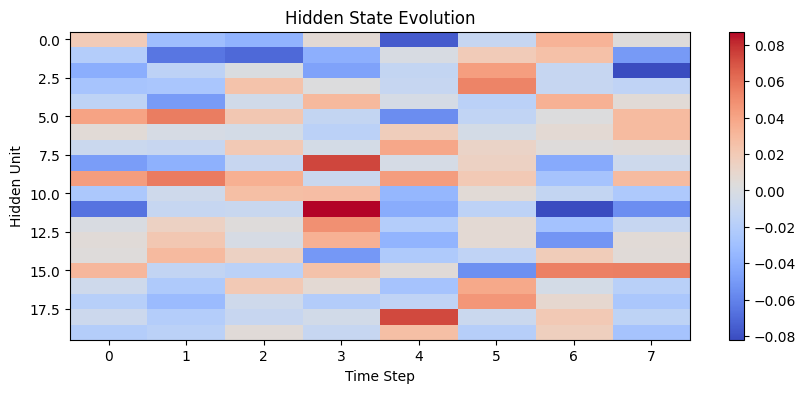

In [64]:
hidden_array = np.array(hidden_states).squeeze()
"""
Dead neurons: Horizontal lines that stay near 0 (blue/cold) indicate unused hidden units
Active neurons: Bright red/blue bands show which units are doing the work
Saturation: Very bright areas might indicate saturated neurons (stuck at ±1 with tanh)
"""
plt.figure(figsize=(10, 4))
plt.imshow(hidden_array.T, aspect='auto', cmap='coolwarm')
plt.colorbar()
plt.xlabel('Time Step')
plt.ylabel('Hidden Unit')
plt.title('Hidden State Evolution')
plt.show()

